In [8]:
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import lightgbm as lgb

from catboost import CatBoostClassifier, CatBoostRegressor

from tqdm import tqdm

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, matthews_corrcoef, precision_score, recall_score, make_scorer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Data Preparation + Insights

In [9]:
RANDOM_STATE = 42 
LABEL_COLS = ["CPPG.STATUS_SPS", "CPPG.STATUS_U0", "CPPG.STATUS_HEIGHT", "CPPG.STATUS_IMPEDANCE", "CPPG.STATUS_FORMATION", "CPPG.STATUS_MODUL"]

In [4]:
df = pd.read_excel("Data/TMTSA_Daten.xlsx")

Remove all Columns with only 1 value (no information gain for the algorithm) --> Removing 24 Columns

In [54]:
columns_without_information_gain = []

for column in df.columns:
    if len(df[column].value_counts()) == 1:
        columns_without_information_gain.append(column)

df_only_information_gain = df.drop(columns_without_information_gain, axis=1)

In [55]:
columns_without_information_gain

['CPW.Werk',
 'CPW.CATHODE_FZLENGTH_LOWER',
 'CPM.Werk',
 'CPX.Werk',
 'CPFORM.SenderName',
 'CPFORM.PROCESSDESCRIPTION',
 'CPFORM.Werk',
 'CPPG.Werk',
 'CPPG.STATUS_MODUL',
 'CPX.Werk_1',
 'CPX.Werk_2',
 'CPW.QUALITY_INSPECTION',
 'CPX.CONV_Result001_1',
 'CPM.RejectScan',
 'CPM.RejectScan1',
 'CPX.CONV_Result001_2',
 'CPX.CONV_ACOHs047_2',
 'CPX.CONV_ACOHs048_2',
 'CPM.RejectWelding',
 'CPPG.REJECTED',
 'CPW.Soll_DMC',
 'CPX.CONV_ACOHs049',
 'CPX.CONV_ACOHs050',
 'CPM.WeldLogfile_Nr']

In [56]:
df_only_information_gain.head()

,Unnamed: 0,ID,CPW.Name,CPW.Linie,CPW.Timestamp,CPW.ANODE_FZLENGTH,CPW.ANODE_LENGTH,CPW.CATHODE_FZLENGTH_UPPER,CPW.CATHODE_LENGTH,CPW.DIAMTER_MAX,...,CPX.CONV_ACOHs043_2,CPX.CONV_ACOHs044_2,CPX.CONV_ACOHs045_2,CPX.CONV_ACOHs046_2,CPX.AI_ACOHs055,CPX.AI_ACOHs056,CPX.CONV_ACOHs045_1,CPX.CONV_ACOHs046_1,CPX.CONV_ACOHs047_1,CPX.CONV_ACOHs048_1
0,0,1,CPMW26,710.0,2022-08-29 02:00:32,61.268271,350.282969,9.179729,302.502813,12.28662,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,CPMW23,707.0,2022-08-20 12:42:20,57.259561,348.452969,10.880899,301.902344,12.26344,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,3,CPMW53,725.0,2022-08-31 16:23:37,58.295284,351.588750,10.690954,302.626719,12.29760,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,4,CPMW27,711.0,2022-10-11 17:54:46,62.750492,351.843710,10.240900,303.179531,12.22806,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,5,CPMW23,707.0,2022-08-24 22:20:35,57.823748,350.698770,10.889323,310.547188,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Manually removing unnecessary and forbidden columns

In [57]:
unnecessary_columns = [
        "Unnamed: 0", 
        "ID", 
        "CPW.Linie", 
        "CPM.Linie", 
        "CPM.CellcodeGrade", 
        "CPM.Weld_Logfile_Nr", 
        "CPX.Linie", 
        "CPFORM.Filename", 
        "CPFORM.TestNumber", 
        "CPFORM.Reasoncode", 
        "CPFORM.Reasoncodename", 
        "CPX.TrayResult"
    ]

not_allowed_columns = [
        "CPPG.SenderName", 
        "CPPG.SenderTimestamp", 
        "CPPG.Impedance_mOhm", 
        "CPPG.Height_mm", 
        "CPPG.U0_mV", 
        "CPPG.Cell Status",
        "CPPG.STATUS_SPS",
        "CPPG.STATUS_U0",
        "CPPG.STATUS_HEIGHT",
        "CPPG.STATUS_IMPEDANCE",
        "CPPG.STATUS_FORMATION"
    ]

df_removed_cols = df_only_information_gain.drop(unnecessary_columns + not_allowed_columns, axis=1)

In [58]:
df_removed_cols.head()

,CPW.Name,CPW.Timestamp,CPW.ANODE_FZLENGTH,CPW.ANODE_LENGTH,CPW.CATHODE_FZLENGTH_UPPER,CPW.CATHODE_LENGTH,CPW.DIAMTER_MAX,CPW.DIAMTER_MIN,CPW.DIAMTER_AVERAGE,CPW.ANODETABPOSITION,...,CPX.CONV_ACOHs043_2,CPX.CONV_ACOHs044_2,CPX.CONV_ACOHs045_2,CPX.CONV_ACOHs046_2,CPX.AI_ACOHs055,CPX.AI_ACOHs056,CPX.CONV_ACOHs045_1,CPX.CONV_ACOHs046_1,CPX.CONV_ACOHs047_1,CPX.CONV_ACOHs048_1
0,CPMW26,2022-08-29 02:00:32,61.268271,350.282969,9.179729,302.502813,12.28662,12.03286,12.12436,91.861033,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CPMW23,2022-08-20 12:42:20,57.259561,348.452969,10.880899,301.902344,12.26344,12.13656,12.20000,49.241435,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CPMW53,2022-08-31 16:23:37,58.295284,351.588750,10.690954,302.626719,12.29760,12.04140,12.14632,120.583939,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CPMW27,2022-10-11 17:54:46,62.750492,351.843710,10.240900,303.179531,12.22806,12.04628,12.11948,368.920286,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CPMW23,2022-08-24 22:20:35,57.823748,350.698770,10.889323,310.547188,0.00000,0.00000,0.00000,196.501964,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Cluster the retests and save the information as bool/num variable

In [59]:
x_ray_0_cols = [f"CPX.AI_ACOHs00{i}" if i < 10 else f"CPX.AI_ACOHs0{i}" for i in range(1, 53)] + [
    "CPX.AI_Result001", 
    "CPX.Tab_Overhang001", 
    "CPX.DIFF_Y1001", 
    "CPX.DIFF_Y2001",
    "CPX.Failure_Code001",
    "CPX.Name",
    "CPX.Xray_Timestamp",
    "CPX.Result"
]

x_ray_1_cols = [f"CPX.AI_ACOHs00{i}_1" if i < 10 else f"CPX.AI_ACOHs0{i}_1" for i in range(1, 53)] + [
    "CPX.AI_Result001_1", 
    "CPX.Tab_Overhang001_1", 
    "CPX.DIFF_Y1001_1", 
    "CPX.DIFF_Y2001_1",
    "CPX.Failure_Code001_1",
    "CPX.Name_1",
    "CPX.Xray_Timestamp_1",
    "CPX.Result_1"
]

x_ray_2_cols = [f"CPX.AI_ACOHs00{i}_2" if i < 10 else f"CPX.AI_ACOHs0{i}_2" for i in range(1, 53)] + [
    "CPX.AI_Result001_2", 
    "CPX.Tab_Overhang001_2", 
    "CPX.DIFF_Y1001_2", 
    "CPX.DIFF_Y2001_2",
    "CPX.Failure_Code001_2",
    "CPX.Name_2",
    "CPX.Xray_Timestamp_2",
    "CPX.Result_2"
]

In [60]:
df_x_ray_cluster = df_removed_cols.copy()
retest_bool = []
retest_num = []

for index, row in df_removed_cols.iterrows():
    for position, column in enumerate(x_ray_0_cols):
        boolean = None
        number = None
        if not pd.isna(row[x_ray_2_cols[position]]):
            df_x_ray_cluster.loc[index, column] = row[x_ray_2_cols[position]]  
            boolean = True
            number = 2
        elif not pd.isna(row[x_ray_1_cols[position]]):
            df_x_ray_cluster.loc[index, column] = row[x_ray_1_cols[position]]
            boolean = True
            number = 1
        else:
            boolean = False
            number = 0
    retest_bool.append(boolean)
    retest_num.append(number)

df_x_ray_cluster["CPX.Retest_Bool"] = retest_bool
df_x_ray_cluster["CPX.Retest_Num"] = retest_num

In [63]:
# Removing 120 columns (still some x ray cols included which will be removed based on feature importance)
df_x_ray_cleaned = df_x_ray_cluster.drop(x_ray_1_cols + x_ray_2_cols, axis=1)

In [64]:
df_x_ray_cleaned["CPX.Retest_Num"].value_counts()

CPX.Retest_Num
0    981788
1     18099
2       113
Name: count, dtype: int64

In [65]:
df_x_ray_cleaned.head()

,CPW.Name,CPW.Timestamp,CPW.ANODE_FZLENGTH,CPW.ANODE_LENGTH,CPW.CATHODE_FZLENGTH_UPPER,CPW.CATHODE_LENGTH,CPW.DIAMTER_MAX,CPW.DIAMTER_MIN,CPW.DIAMTER_AVERAGE,CPW.ANODETABPOSITION,...,CPX.CONV_ACOHs045_2,CPX.CONV_ACOHs046_2,CPX.AI_ACOHs055,CPX.AI_ACOHs056,CPX.CONV_ACOHs045_1,CPX.CONV_ACOHs046_1,CPX.CONV_ACOHs047_1,CPX.CONV_ACOHs048_1,CPX.Retest_Bool,CPX.Retest_Num
0,CPMW26,2022-08-29 02:00:32,61.268271,350.282969,9.179729,302.502813,12.28662,12.03286,12.12436,91.861033,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0
1,CPMW23,2022-08-20 12:42:20,57.259561,348.452969,10.880899,301.902344,12.26344,12.13656,12.20000,49.241435,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0
2,CPMW53,2022-08-31 16:23:37,58.295284,351.588750,10.690954,302.626719,12.29760,12.04140,12.14632,120.583939,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0
3,CPMW27,2022-10-11 17:54:46,62.750492,351.843710,10.240900,303.179531,12.22806,12.04628,12.11948,368.920286,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0
4,CPMW23,2022-08-24 22:20:35,57.823748,350.698770,10.889323,310.547188,0.00000,0.00000,0.00000,196.501964,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0


Duration aus Timestamps berechnen und originale Timestamps entfernen

In [66]:
# df_x_ray_cluster["CPW.Duration"] = 
cpw_duration = df_x_ray_cleaned["CPM.Timestamp"]-df_x_ray_cleaned["CPW.Timestamp"]
cpw_duration = cpw_duration.dt.total_seconds()

cpm_duration = df_x_ray_cleaned["CPX.Xray_Timestamp"]-df_x_ray_cleaned["CPM.Timestamp"]
cpm_duration = cpm_duration.dt.total_seconds()

df_x_ray_cleaned["CPW.Duration"] = cpw_duration
df_x_ray_cleaned["CPM.Duration"] = cpm_duration

df_prepared = df_x_ray_cleaned.drop(["CPW.Timestamp", "CPM.Timestamp", "CPX.Xray_Timestamp"], axis=1) # Remove unnecessary timestamps (other timestamps will be removed later as CPForm data will be removed)

In [67]:
df_prepared.head()

,CPW.Name,CPW.ANODE_FZLENGTH,CPW.ANODE_LENGTH,CPW.CATHODE_FZLENGTH_UPPER,CPW.CATHODE_LENGTH,CPW.DIAMTER_MAX,CPW.DIAMTER_MIN,CPW.DIAMTER_AVERAGE,CPW.ANODETABPOSITION,CPW.CATHODETABPOSITION,...,CPX.AI_ACOHs055,CPX.AI_ACOHs056,CPX.CONV_ACOHs045_1,CPX.CONV_ACOHs046_1,CPX.CONV_ACOHs047_1,CPX.CONV_ACOHs048_1,CPX.Retest_Bool,CPX.Retest_Num,CPW.Duration,CPM.Duration
0,CPMW26,61.268271,350.282969,9.179729,302.502813,12.28662,12.03286,12.12436,91.861033,1.173663,...,NaN,NaN,NaN,NaN,NaN,NaN,False,0,395044.0,33503.0
1,CPMW23,57.259561,348.452969,10.880899,301.902344,12.26344,12.13656,12.20000,49.241435,402.458856,...,NaN,NaN,NaN,NaN,NaN,NaN,False,0,734387.0,2131.0
2,CPMW53,58.295284,351.588750,10.690954,302.626719,12.29760,12.04140,12.14632,120.583939,53.235782,...,NaN,NaN,NaN,NaN,NaN,NaN,False,0,335387.0,19343.0
3,CPMW27,62.750492,351.843710,10.240900,303.179531,12.22806,12.04628,12.11948,368.920286,268.658312,...,NaN,NaN,NaN,NaN,NaN,NaN,False,0,126924.0,32637.0
4,CPMW23,57.823748,350.698770,10.889323,310.547188,0.00000,0.00000,0.00000,196.501964,106.837010,...,NaN,NaN,NaN,NaN,NaN,NaN,False,0,476852.0,32222.0


Removing the cp_form step values (12 Columns)

In [68]:
cp_form_features = ["CPFORM.SenderTimestamp", "CPFORM.StartTime", "CPFORM.Duration_s", "CPFORM.TrayXID", "CPFORM.TrayPosition", "CPFORM.QualityStatus", "CPFORM.Grade", "CPFORM.ChgCap_mAh_Cycle0/0", "CPFORM.DsgCap_mAh_Cycle0/0", "CPFORM.OCV1_mV", "CPFORM.OCV1_Timestamp", "CPFORM.Rack"]

df_no_cp_form = df_prepared.drop(cp_form_features, axis=1)

In [69]:
df_no_cp_form.head()

,CPW.Name,CPW.ANODE_FZLENGTH,CPW.ANODE_LENGTH,CPW.CATHODE_FZLENGTH_UPPER,CPW.CATHODE_LENGTH,CPW.DIAMTER_MAX,CPW.DIAMTER_MIN,CPW.DIAMTER_AVERAGE,CPW.ANODETABPOSITION,CPW.CATHODETABPOSITION,...,CPX.AI_ACOHs055,CPX.AI_ACOHs056,CPX.CONV_ACOHs045_1,CPX.CONV_ACOHs046_1,CPX.CONV_ACOHs047_1,CPX.CONV_ACOHs048_1,CPX.Retest_Bool,CPX.Retest_Num,CPW.Duration,CPM.Duration
0,CPMW26,61.268271,350.282969,9.179729,302.502813,12.28662,12.03286,12.12436,91.861033,1.173663,...,NaN,NaN,NaN,NaN,NaN,NaN,False,0,395044.0,33503.0
1,CPMW23,57.259561,348.452969,10.880899,301.902344,12.26344,12.13656,12.20000,49.241435,402.458856,...,NaN,NaN,NaN,NaN,NaN,NaN,False,0,734387.0,2131.0
2,CPMW53,58.295284,351.588750,10.690954,302.626719,12.29760,12.04140,12.14632,120.583939,53.235782,...,NaN,NaN,NaN,NaN,NaN,NaN,False,0,335387.0,19343.0
3,CPMW27,62.750492,351.843710,10.240900,303.179531,12.22806,12.04628,12.11948,368.920286,268.658312,...,NaN,NaN,NaN,NaN,NaN,NaN,False,0,126924.0,32637.0
4,CPMW23,57.823748,350.698770,10.889323,310.547188,0.00000,0.00000,0.00000,196.501964,106.837010,...,NaN,NaN,NaN,NaN,NaN,NaN,False,0,476852.0,32222.0


In [70]:
# Calculate the min an max value for each column, which includes error values
# The idea is that each error value will be 0 after replacement + normalization so the "error" needs to be replaced 
# --> so this value will be replaced with the min value of the column - d * range of the column

replacement_dict = {}

for i in range(1, 49):
    for j in range(3):
        col_name = None
        if (i == 47 or i == 48) and j == 2:
            continue
        if i < 10:
            if j == 0:
                col_name = f"CPX.CONV_ACOHs00{i}"
            else:
                col_name = f"CPX.CONV_ACOHs00{i}_{j}"
        else:
            if j == 0:
                col_name = f"CPX.CONV_ACOHs0{i}"
            else:
                col_name = f"CPX.CONV_ACOHs0{i}_{j}"
        column = df_no_cp_form[col_name]
        column_no_error = column[~column.isin(["error"])].mean()
        column = column.replace("error", column_no_error.mean())
        replacement_dict[col_name] = [column.min(), column.max()]

Manually encode columns with mixed datatypes (f.e. floating values in object column --> no label encoding in raw form possible)

In [71]:
df_replaced = df_no_cp_form.copy()
d = 0.1

for i in range(1, 49):
    for j in range(3):
        col_name = None
        if (i == 47 or i == 48) and j == 2:
            continue
        if i < 10:
            if j == 0:
                col_name = f"CPX.CONV_ACOHs00{i}"
            else:
                col_name = f"CPX.CONV_ACOHs00{i}_{j}"
        else:
            if j == 0:
                col_name = f"CPX.CONV_ACOHs0{i}"
            else:
                col_name = f"CPX.CONV_ACOHs0{i}_{j}"
        max_val = replacement_dict[col_name][1]
        min_val = replacement_dict[col_name][0]
        replacement_value = min_val - d * (max_val - min_val)
        df_replaced[col_name] = df_no_cp_form[col_name].replace("error", replacement_value)

Encode remaining values to categorical --> save classes in dict for possible decoding

In [72]:
df_encoded = df_replaced.copy()
encoding_dict = {}

for index, val in enumerate(df_replaced.dtypes):
    if val == "object" or val == "datetime64[ns]":
        col_name = df_replaced.columns[index]
        print(col_name)
        le = LabelEncoder()
        df_encoded[col_name] = le.fit_transform(df_replaced[col_name])
        encoding_dict[col_name] = le.classes_

CPW.Name
CPM.MaxTimeWT
CPM.Name
CPX.AI_Result001
CPX.Name
CPX.Result
CPX.Linie_1
CPX.TrayResult_1
CPX.CONV_Result001
CPX.Linie_2
CPX.TrayResult_2


In [73]:
df_encoded.head()

,CPW.Name,CPW.ANODE_FZLENGTH,CPW.ANODE_LENGTH,CPW.CATHODE_FZLENGTH_UPPER,CPW.CATHODE_LENGTH,CPW.DIAMTER_MAX,CPW.DIAMTER_MIN,CPW.DIAMTER_AVERAGE,CPW.ANODETABPOSITION,CPW.CATHODETABPOSITION,...,CPX.AI_ACOHs055,CPX.AI_ACOHs056,CPX.CONV_ACOHs045_1,CPX.CONV_ACOHs046_1,CPX.CONV_ACOHs047_1,CPX.CONV_ACOHs048_1,CPX.Retest_Bool,CPX.Retest_Num,CPW.Duration,CPM.Duration
0,5,61.268271,350.282969,9.179729,302.502813,12.28662,12.03286,12.12436,91.861033,1.173663,...,NaN,NaN,NaN,NaN,NaN,NaN,False,0,395044.0,33503.0
1,2,57.259561,348.452969,10.880899,301.902344,12.26344,12.13656,12.20000,49.241435,402.458856,...,NaN,NaN,NaN,NaN,NaN,NaN,False,0,734387.0,2131.0
2,16,58.295284,351.588750,10.690954,302.626719,12.29760,12.04140,12.14632,120.583939,53.235782,...,NaN,NaN,NaN,NaN,NaN,NaN,False,0,335387.0,19343.0
3,6,62.750492,351.843710,10.240900,303.179531,12.22806,12.04628,12.11948,368.920286,268.658312,...,NaN,NaN,NaN,NaN,NaN,NaN,False,0,126924.0,32637.0
4,2,57.823748,350.698770,10.889323,310.547188,0.00000,0.00000,0.00000,196.501964,106.837010,...,NaN,NaN,NaN,NaN,NaN,NaN,False,0,476852.0,32222.0


Min Max Normalization for each column --> save min and max value for each column befor normalization for possible decoding

In [74]:
normalization_dict = {}

for index, name in enumerate(df_encoded.columns):
    normalization_dict[name] = [df_encoded[name].min(), df_encoded[name].max()]

scaler = MinMaxScaler()
df_scaled = df_encoded.apply(lambda column: pd.Series(scaler.fit_transform(column.values.reshape(-1, 1)).flatten()))


In [75]:
df_scaled.head()

,CPW.Name,CPW.ANODE_FZLENGTH,CPW.ANODE_LENGTH,CPW.CATHODE_FZLENGTH_UPPER,CPW.CATHODE_LENGTH,CPW.DIAMTER_MAX,CPW.DIAMTER_MIN,CPW.DIAMTER_AVERAGE,CPW.ANODETABPOSITION,CPW.CATHODETABPOSITION,...,CPX.AI_ACOHs055,CPX.AI_ACOHs056,CPX.CONV_ACOHs045_1,CPX.CONV_ACOHs046_1,CPX.CONV_ACOHs047_1,CPX.CONV_ACOHs048_1,CPX.Retest_Bool,CPX.Retest_Num,CPW.Duration,CPM.Duration
0,0.192308,0.301151,0.003236,0.686540,0.006666,0.977767,0.981295,0.984448,0.209158,0.002674,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.118489,0.007054
1,0.076923,0.285979,0.003219,0.813174,0.006653,0.975922,0.989752,0.990589,0.112118,0.916349,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.220644,0.004977
2,0.615385,0.289899,0.003248,0.799034,0.006668,0.978641,0.981992,0.986231,0.274556,0.121213,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.100530,0.006116
3,0.230769,0.306761,0.003250,0.765533,0.006681,0.973107,0.982390,0.984051,0.839987,0.611703,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.037775,0.006997
4,0.076923,0.288114,0.003240,0.813801,0.006843,0.000000,0.000000,0.000000,0.447412,0.243256,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.143117,0.006969


Remove N/A values --> Categorical data with modus / Numerical Data with mean (Categorical values are all stored in the encoding dict; manual encoding was all on numerical values)

--> After checking the values, there is no missing value for the categorical data, so only the missing numerical values will be calculated (can be checked with code below but takes 30min)

In [132]:
# for col_idx, column in enumerate(df_scaled.columns):
#     for row_idx, cell in enumerate(df_scaled[column]):
#         if pd.isna(df_scaled.loc[row_idx, column]):
#             if column in encoding_dict.keys():
#                 print(column)

In [76]:
final_df = df_scaled.copy()

for column in final_df.columns:
    mean_value = final_df[column].mean()
    final_df[column] = final_df[column].fillna(mean_value)

In [77]:
# Check that no N/A is remaining
for val in final_df.isna().sum():
    if val != 0:
        print(val)

In [78]:
final_df.head()

,CPW.Name,CPW.ANODE_FZLENGTH,CPW.ANODE_LENGTH,CPW.CATHODE_FZLENGTH_UPPER,CPW.CATHODE_LENGTH,CPW.DIAMTER_MAX,CPW.DIAMTER_MIN,CPW.DIAMTER_AVERAGE,CPW.ANODETABPOSITION,CPW.CATHODETABPOSITION,...,CPX.AI_ACOHs055,CPX.AI_ACOHs056,CPX.CONV_ACOHs045_1,CPX.CONV_ACOHs046_1,CPX.CONV_ACOHs047_1,CPX.CONV_ACOHs048_1,CPX.Retest_Bool,CPX.Retest_Num,CPW.Duration,CPM.Duration
0,0.192308,0.301151,0.003236,0.686540,0.006666,0.977767,0.981295,0.984448,0.209158,0.002674,...,0.346099,0.323453,0.407145,0.53664,0.5,0.0,0.0,0.0,0.118489,0.007054
1,0.076923,0.285979,0.003219,0.813174,0.006653,0.975922,0.989752,0.990589,0.112118,0.916349,...,0.346099,0.323453,0.407145,0.53664,0.5,0.0,0.0,0.0,0.220644,0.004977
2,0.615385,0.289899,0.003248,0.799034,0.006668,0.978641,0.981992,0.986231,0.274556,0.121213,...,0.346099,0.323453,0.407145,0.53664,0.5,0.0,0.0,0.0,0.100530,0.006116
3,0.230769,0.306761,0.003250,0.765533,0.006681,0.973107,0.982390,0.984051,0.839987,0.611703,...,0.346099,0.323453,0.407145,0.53664,0.5,0.0,0.0,0.0,0.037775,0.006997
4,0.076923,0.288114,0.003240,0.813801,0.006843,0.000000,0.000000,0.000000,0.447412,0.243256,...,0.346099,0.323453,0.407145,0.53664,0.5,0.0,0.0,0.0,0.143117,0.006969


In [79]:
# with open("final_df.pickle", "wb") as f:
#     pickle.dump(final_df, f)

# with open("initial_df.pickle", "wb") as f:
#     pickle.dump(df, f)

# -------------------------------------- LABELS ----------------------------------------

In [80]:
cppg_df = df[LABEL_COLS]
cppg_df.head()

,CPPG.STATUS_SPS,CPPG.STATUS_U0,CPPG.STATUS_HEIGHT,CPPG.STATUS_IMPEDANCE,CPPG.STATUS_FORMATION,CPPG.STATUS_MODUL
0,PASS,PASS,PASS,PASS,PASS,NaN
1,PASS,PASS,PASS,PASS,NaN,PASS
2,PASS,PASS,PASS,PASS,NaN,PASS
3,PASS,PASS,PASS,PASS,PASS,NaN
4,PASS,PASS,PASS,PASS,PASS,NaN


In [81]:
for column in cppg_df.columns:
    print(cppg_df[column].value_counts())

CPPG.STATUS_SPS
PASS              973404
IMPEDANCE_FAIL     12876
VOLTAGE_FAIL        8392
U0_FAIL             2560
FORMATION_FAIL      1507
HEIGHT_FAIL         1201
NO CELL               51
_FAIL                  9
Name: count, dtype: int64
CPPG.STATUS_U0
PASS       987590
FAIL        12359
NO CELL        51
Name: count, dtype: int64
CPPG.STATUS_HEIGHT
PASS       998619
FAIL         1330
NO CELL        51
Name: count, dtype: int64
CPPG.STATUS_IMPEDANCE
PASS       985586
FAIL        14363
NO CELL        51
Name: count, dtype: int64
CPPG.STATUS_FORMATION
PASS       400555
FAIL         1507
NO CELL        51
Name: count, dtype: int64
CPPG.STATUS_MODUL
PASS    597887
Name: count, dtype: int64


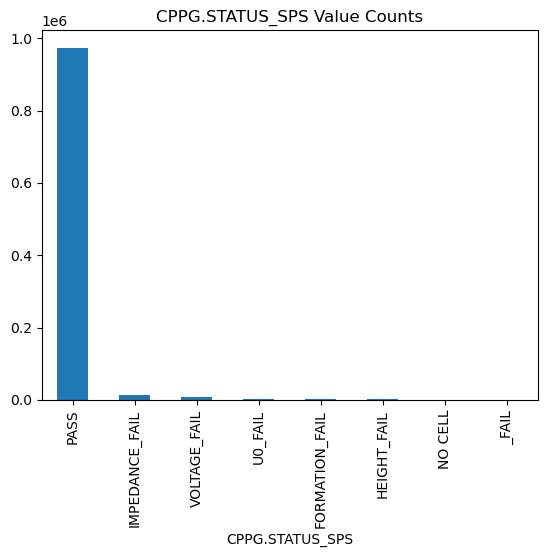

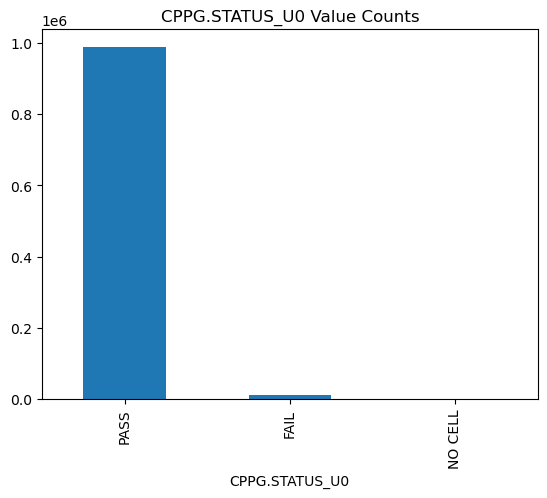

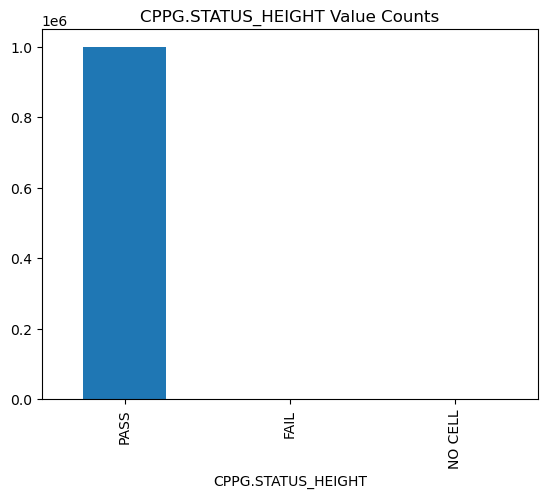

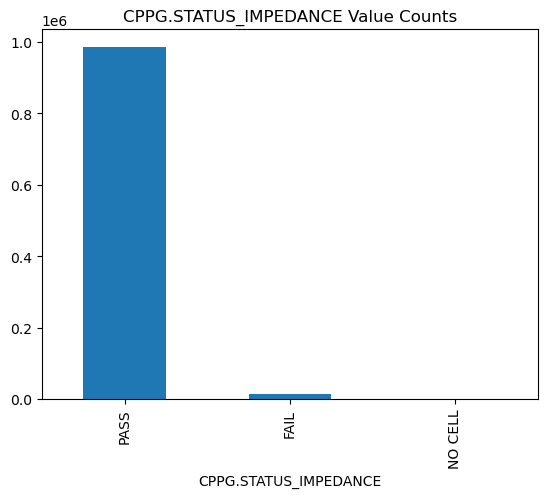

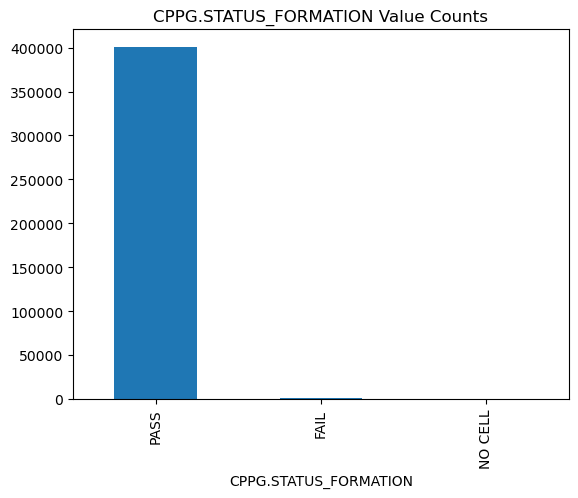

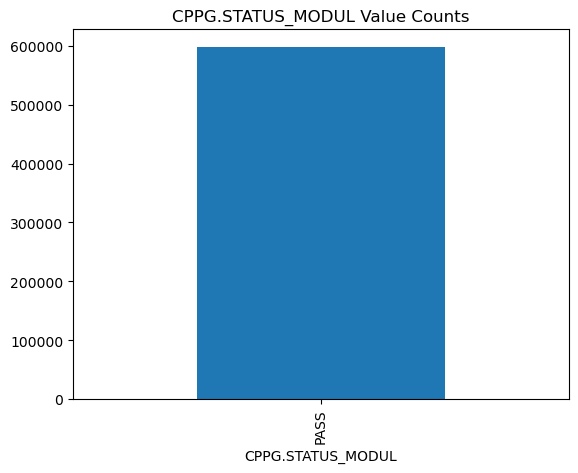

In [82]:
for column in cppg_df.columns:
    plt.figure()
    cppg_df[column].value_counts().plot.bar()
    plt.title(f'{column} Value Counts')
plt.show()

TODO: zuerst prüfen ob Classification Binary möglich, dann multi-class (different Failures)

In [83]:
# Check here, whether other Fail Values are in DF
y = []

contains_failure = cppg_df.isin(["FAIL"]).any(axis=1)

for item in contains_failure:
    if item:
        y.append("FAIL")
    else:
        y.append("PASS")

In [33]:
# with open("labels_clustered.pickle", "wb") as f:
#     pickle.dump(y, f)

# with open("labels.pickle", "wb") as f:
#     pickle.dump(cppg_df, f)

In [10]:
with open("final_df.pickle", "rb") as f:
    final_df = pickle.load(f)

with open("labels.pickle", "rb") as f:
    y = pickle.load(f)

with open("labels_clustered.pickle", "rb") as f:
    y_clustered = pickle.load(f)

In [11]:
le = LabelEncoder()
y_encoded = le.fit_transform(y_clustered)

value_distribution = pd.DataFrame([le.classes_[line] for line in y_encoded])
print(value_distribution.value_counts())

PASS    973464
FAIL     26536
dtype: int64


### Initial Creation of Hold Out set

In [12]:
x_train, x_test, y_train, y_test = train_test_split(final_df, y_encoded, test_size=0.2, random_state=RANDOM_STATE)

### Undersampling train values for testing

In [13]:
rus = RandomUnderSampler(random_state=RANDOM_STATE)

x_resampled, y_resampled = rus.fit_resample(x_train, y_train)

# Different Models Comparison

## Spot Checking

In [14]:
def all_models():
    return [
        ('Decision Tree', DecisionTreeClassifier(random_state=RANDOM_STATE)),
        ('Random Forest', RandomForestClassifier(random_state=RANDOM_STATE)),
        ('Extremely Randomized Trees', ExtraTreesClassifier(random_state=RANDOM_STATE)),
        ('Ada Boost', AdaBoostClassifier(random_state=RANDOM_STATE)),
        ('Gradient Boosting', GradientBoostingClassifier(random_state=RANDOM_STATE)),
        ('Support Vector Machine', SVC(random_state=RANDOM_STATE)),
        # ('Multilayer Perceptron', MLPClassifier(random_state=RANDOM_STATE)),
        ('Naive Bayes', GaussianNB()),
        ('LGBM', lgb.LGBMClassifier(random_state=RANDOM_STATE)),
        ('Catboost', CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, random_state=RANDOM_STATE))
    ]

scorings = {
    'accuracy': make_scorer(accuracy_score),
    'balanced_accuracy': make_scorer(balanced_accuracy_score),
    'f1_score': make_scorer(f1_score),
    'mcc': make_scorer(matthews_corrcoef),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
}

# Neural Network initial hyperparams
# define the callbacks
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5)
dropout = 0.2

In [82]:
all_cv_scores = []

for classifier_name, classifier in tqdm(all_models()):
    print(f"[INFO] ---- Validation for {classifier_name}")
    formatted_result = {}
    formatted_result['Classifier'] = classifier_name

    cv_score = cross_validate(estimator=classifier, X=x_resampled, y=y_resampled, scoring=scorings)

    for score_name, scores in cv_score.items():
        formatted_result[f'{score_name}_mean'] = np.mean(scores)
        formatted_result[f'{score_name}_std'] = np.std(scores)

    all_cv_scores.append(formatted_result)

  0%|          | 0/9 [00:00<?, ?it/s]

[INFO] ---- Validation for Decision Tree


 11%|█         | 1/9 [00:30<04:06, 30.84s/it]

[INFO] ---- Validation for Random Forest


 22%|██▏       | 2/9 [02:57<11:32, 98.98s/it]

[INFO] ---- Validation for Extremely Randomized Trees


 33%|███▎      | 3/9 [03:51<07:51, 78.56s/it]

[INFO] ---- Validation for Ada Boost


 44%|████▍     | 4/9 [05:43<07:39, 91.82s/it]

[INFO] ---- Validation for Gradient Boosting


 56%|█████▌    | 5/9 [15:18<17:43, 265.85s/it]

[INFO] ---- Validation for Support Vector Machine


 67%|██████▋   | 6/9 [31:22<25:09, 503.11s/it]

[INFO] ---- Validation for Naive Bayes


 78%|███████▊  | 7/9 [31:23<11:18, 339.07s/it]

[INFO] ---- Validation for LGBM


 89%|████████▉ | 8/9 [31:27<03:52, 232.57s/it]

[INFO] ---- Validation for Catboost
0:	learn: 0.6710233	total: 30.7ms	remaining: 30.7s
1:	learn: 0.6537308	total: 60.2ms	remaining: 30s
2:	learn: 0.6380625	total: 89.6ms	remaining: 29.8s
3:	learn: 0.6266996	total: 120ms	remaining: 29.8s
4:	learn: 0.6169205	total: 149ms	remaining: 29.7s
5:	learn: 0.6095747	total: 178ms	remaining: 29.4s
6:	learn: 0.6032881	total: 207ms	remaining: 29.4s
7:	learn: 0.5980902	total: 237ms	remaining: 29.3s
8:	learn: 0.5936276	total: 266ms	remaining: 29.3s
9:	learn: 0.5899241	total: 296ms	remaining: 29.3s
10:	learn: 0.5866847	total: 325ms	remaining: 29.2s
11:	learn: 0.5832134	total: 354ms	remaining: 29.2s
12:	learn: 0.5802870	total: 383ms	remaining: 29.1s
13:	learn: 0.5778465	total: 413ms	remaining: 29.1s
14:	learn: 0.5760834	total: 441ms	remaining: 29s
15:	learn: 0.5745886	total: 469ms	remaining: 28.9s
16:	learn: 0.5727989	total: 499ms	remaining: 28.9s
17:	learn: 0.5714269	total: 529ms	remaining: 28.8s
18:	learn: 0.5702777	total: 559ms	remaining: 28.9s
19:	le

100%|██████████| 9/9 [33:47<00:00, 225.30s/it]


In [83]:
pd.DataFrame(all_cv_scores)

,Classifier,fit_time_mean,fit_time_std,score_time_mean,score_time_std,test_accuracy_mean,test_accuracy_std,test_balanced_accuracy_mean,test_balanced_accuracy_std,test_f1_score_mean,test_f1_score_std,test_mcc_mean,test_mcc_std,test_precision_mean,test_precision_std,test_recall_mean,test_recall_std
0,Decision Tree,6.141959,0.135236,0.022208,0.000748,0.642362,0.003540,0.642362,0.003540,0.641450,0.003018,0.284740,0.007079,0.643121,0.004381,0.639815,0.004129
1,Random Forest,29.159612,0.187185,0.162264,0.002291,0.726478,0.005383,0.726477,0.005382,0.722593,0.006194,0.453151,0.010718,0.732968,0.004857,0.712541,0.008744
2,Extremely Randomized Trees,10.622417,0.127521,0.217190,0.002308,0.724780,0.005765,0.724779,0.005765,0.724592,0.006212,0.449581,0.011516,0.725075,0.005691,0.724143,0.008327
3,Ada Boost,22.143035,0.100199,0.283085,0.003611,0.713012,0.005493,0.713012,0.005492,0.709222,0.006866,0.426196,0.010878,0.718653,0.004360,0.700090,0.010476
4,Gradient Boosting,114.843002,1.816305,0.036408,0.001020,0.722610,0.004445,0.722610,0.004444,0.715664,0.004851,0.445760,0.008874,0.734038,0.004578,0.698203,0.006041
5,Support Vector Machine,154.358210,1.218945,38.365533,1.271983,0.693770,0.006997,0.693770,0.006995,0.678872,0.008322,0.389218,0.013853,0.713520,0.006534,0.647456,0.010156
6,Naive Bayes,0.215241,0.010270,0.051472,0.001949,0.522143,0.001736,0.522143,0.001725,0.675204,0.001045,0.132642,0.009010,0.511400,0.000915,0.993397,0.002088
7,LGBM,0.839256,0.019264,0.052460,0.001746,0.735250,0.004875,0.735250,0.004875,0.729989,0.005896,0.470869,0.009642,0.744735,0.003710,0.715843,0.008503
8,Catboost,27.921238,0.487049,0.024606,0.001357,0.736736,0.005776,0.736736,0.005776,0.734572,0.006231,0.473540,0.011531,0.740631,0.005333,0.728624,0.007553


For Keras KNN, the kFold has to be implemented in another way to handle one hot encoded labels

In [84]:
kfold = KFold(n_splits=5, shuffle=True)

x_resampled_arr = np.array(x_resampled)
y_resampled_arr = to_categorical(np.array(y_resampled))

accuracies = []
f1_scores = []

fold = 0
for train_index, val_index in kfold.split(x_resampled_arr):
    fold += 1
    print(f"Fold: {fold}")

    model = Sequential([
        Dense(256, activation='relu', input_shape=(len(x_train.columns),)),
        Dropout(dropout),
        Dense(512, activation='relu'),
        Dropout(dropout),
        Dense(1024, activation='relu'),
        Dropout(dropout),
        Dense(512, activation='relu'),
        Dropout(dropout),
        Dense(256, activation='relu'),
        Dropout(dropout),
        Dense(len(le.classes_), activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=1e-03), loss='binary_crossentropy', metrics=['accuracy'])

    # Split data into training and validation subsets
    x_train_fold, x_val_fold = x_resampled_arr[train_index], x_resampled_arr[val_index]
    y_train_fold, y_val_fold = y_resampled_arr[train_index], y_resampled_arr[val_index]

    # Train the model
    model.fit(x_train_fold, y_train_fold, epochs=10, batch_size=32)

    predictions = model.predict(x_val_fold)
    predictions = np.argmax(predictions, axis=1)
    y_val_fold = np.argmax(y_val_fold, axis=1)

    accuracy = accuracy_score(y_val_fold, predictions)
    f1_value = f1_score(y_val_fold, predictions)
    accuracies.append(accuracy)
    f1_scores.append(f1_value)

accuracies_mean = sum(accuracies) / len(accuracies)
f1_scores_mean = sum(f1_scores) / len(f1_scores)

print(f"Accuracy Mean: {accuracies_mean}")
print(f"F1-Score Mean: {f1_scores_mean}")

Fold: 1
Epoch 1/10
1061/1061 [==============================] - 7s 6ms/step - loss: 0.6923 - accuracy: 0.5147
Epoch 2/10
1061/1061 [==============================] - 8s 8ms/step - loss: 0.6915 - accuracy: 0.5047
Epoch 3/10
1061/1061 [==============================] - 8s 7ms/step - loss: 0.6933 - accuracy: 0.4989
Epoch 4/10
1061/1061 [==============================] - 8s 7ms/step - loss: 0.6932 - accuracy: 0.4981
Epoch 5/10
1061/1061 [==============================] - 8s 8ms/step - loss: 0.6932 - accuracy: 0.4991
Epoch 6/10
1061/1061 [==============================] - 8s 8ms/step - loss: 0.6931 - accuracy: 0.5055
Epoch 7/10
1061/1061 [==============================] - 8s 8ms/step - loss: 0.6932 - accuracy: 0.5021
Epoch 8/10
1061/1061 [==============================] - 8s 8ms/step - loss: 0.6932 - accuracy: 0.4981
Epoch 9/10
1061/1061 [==============================] - 8s 8ms/step - loss: 0.6932 - accuracy: 0.5006
Epoch 10/10
266/266 [==============================] - 0s 1ms/step
Fold: 2

## Feature Selection

In [8]:
cv_amount = 5
number_of_features = [i for i in range(10, 121, 10)] + [127]
all_cv_scores_selected = []

for number_of_feature in number_of_features:
    random_forest = RandomForestClassifier(random_state=RANDOM_STATE)
    random_forest.fit(x_resampled, y_resampled)
    feature_importances = random_forest.feature_importances_[:number_of_feature]
    standard_deviation_importances = np.std([tree.feature_importances_ for tree in random_forest.estimators_], axis=0)[:number_of_feature]

    forest_importances = pd.Series(feature_importances, index=x_resampled.columns[:number_of_feature])
    forest_importances = forest_importances.sort_values()

    selector = SelectFromModel(estimator=random_forest, prefit=True)
    x_data_selected = selector.transform(x_resampled)
    best_features = selector.get_feature_names_out(x_resampled.columns)
    x_data_selected = pd.DataFrame(x_data_selected[:,:number_of_feature], columns=best_features[:number_of_feature])

    x_test_imbalanced_selected = selector.transform(x_test)
    x_test_imbalanced_selected = pd.DataFrame(x_test_imbalanced_selected[:,:number_of_feature], columns=best_features[:number_of_feature])

    kfold = KFold(n_splits=cv_amount, shuffle=True, random_state=RANDOM_STATE)

    for classifier_name, classifier in tqdm(all_models()):
        print(f"[INFO] ---- Validation for {classifier_name}")
        formatted_result_selected = {}
        formatted_result_selected['Classifier'] = classifier_name

        accuracies = []
        balanced_accuracies = []
        f1_scores = []

        fold = 0
        for train_index, test_index in kfold.split(x_data_selected):
            fold += 1

            x_train_fold, x_test_fold_balanced = x_data_selected.iloc[train_index], x_data_selected.iloc[test_index]
            y_train_fold, y_test_fold_balanced = y_resampled[train_index], y_resampled[test_index]

            classifier.fit(x_train_fold, y_train_fold)
            y_pred_balanced = classifier.predict(x_test_fold_balanced)
            
            accuracy = accuracy_score(y_test_fold_balanced, y_pred_balanced)
            balanced_accuracy = balanced_accuracy_score(y_test_fold_balanced, y_pred_balanced)
            f1_value = f1_score(y_test_fold_balanced, y_pred_balanced)
            accuracies.append(accuracy)
            balanced_accuracies.append(balanced_accuracy)
            f1_scores.append(f1_value)

        accuracies_mean = sum(accuracies) / len(accuracies)
        balanced_accuracies_mean = sum(balanced_accuracies) / len(balanced_accuracies)
        f1_scores_mean = sum(f1_scores) / len(f1_scores)

        formatted_result_selected['test_accuracy_mean_balanced'] = accuracies_mean
        formatted_result_selected['test_balanced_accuracy_mean_balanced'] = balanced_accuracies_mean
        formatted_result_selected['test_f1_score_mean_balanced'] = f1_scores_mean

        y_pred_imbalanced = classifier.predict(x_test_imbalanced_selected)

        formatted_result_selected['test_accuracy_mean_imbalanced'] = accuracy_score(y_test, y_pred_imbalanced)
        formatted_result_selected['test_balanced_accuracy_mean_imbalanced'] = balanced_accuracy_score(y_test, y_pred_imbalanced)
        formatted_result_selected['test_f1_score_mean_imbalanced'] = f1_score(y_test, y_pred_imbalanced)
        all_cv_scores_selected.append(formatted_result_selected)

    # define the callbacks
    formatted_result_selected = {}
    formatted_result_selected['Classifier'] = "Neural Network"
    x_selected_arr = np.array(x_data_selected)
    y_selected_arr = to_categorical(np.array(y_resampled))

    accuracies = []
    balanced_accuracies = []
    f1_scores = []

    fold = 0
    for train_index, test_index in kfold.split(x_selected_arr):
        fold += 1

        model = Sequential([
            Dense(256, activation='relu', input_shape=(len(x_data_selected.columns),)),
            Dropout(dropout),
            Dense(512, activation='relu'),
            Dropout(dropout),
            Dense(1024, activation='relu'),
            Dropout(dropout),
            Dense(512, activation='relu'),
            Dropout(dropout),
            Dense(256, activation='relu'),
            Dropout(dropout),
            Dense(len(le.classes_), activation='sigmoid')
        ])
        model.compile(optimizer=Adam(learning_rate=1e-03), loss='binary_crossentropy', metrics=['accuracy'])

        # Split data into training and validation subsets
        x_train_fold, x_test_fold_balanced = x_selected_arr[train_index], x_selected_arr[test_index]
        y_train_fold, y_test_fold_balanced = y_selected_arr[train_index], y_selected_arr[test_index]

        # Train the model
        model.fit(x_train_fold, y_train_fold, epochs=10, batch_size=32)

        predictions_balanced = model.predict(x_test_fold_balanced)
        predictions_balanced = np.argmax(predictions_balanced, axis=1)
        y_test_fold_balanced = np.argmax(y_test_fold_balanced, axis=1)

        accuracy = accuracy_score(y_test_fold_balanced, predictions_balanced)
        balanced_accuracy = balanced_accuracy_score(y_test_fold_balanced, predictions_balanced)
        f1_value = f1_score(y_test_fold_balanced, predictions_balanced)
        accuracies.append(accuracy)
        balanced_accuracies.append(balanced_accuracy)
        f1_scores.append(f1_value)

    accuracies_mean = sum(accuracies) / len(accuracies)
    balanced_accuracies_mean = sum(balanced_accuracies) / len(balanced_accuracies)
    f1_scores_mean = sum(f1_scores) / len(f1_scores)

    formatted_result_selected['test_accuracy_mean_balanced'] = accuracies_mean
    formatted_result_selected['test_balanced_accuracy_mean_balanced'] = balanced_accuracies_mean
    formatted_result_selected['test_f1_score_mean_balanced'] = f1_scores_mean

    predictions_imbalanced = model.predict(x_test_imbalanced_selected)
    predictions_imbalanced = np.argmax(predictions_imbalanced, axis=1)

    formatted_result_selected['test_accuracy_mean_imbalanced'] = accuracy_score(y_test, predictions_imbalanced)
    formatted_result_selected['test_balanced_accuracy_mean_imbalanced'] = balanced_accuracy_score(y_test, predictions_imbalanced)
    formatted_result_selected['test_f1_score_mean_imbalanced'] = f1_score(y_test, predictions_imbalanced)
    all_cv_scores_selected.append(formatted_result_selected)
pd.DataFrame(all_cv_scores_selected).to_excel('feature_importances_test_3.xlsx', index=False)

c:\Users\Dominik Hahn\anaconda3\envs\check_gpu_neu\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Users\Dominik Hahn\anaconda3\envs\check_gpu_neu\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
  0%|          | 0/9 [00:00<?, ?it/s]

[INFO] ---- Validation for Decision Tree


 11%|█         | 1/9 [00:22<02:57, 22.20s/it]

[INFO] ---- Validation for Random Forest


 22%|██▏       | 2/9 [03:18<13:09, 112.75s/it]

[INFO] ---- Validation for Extremely Randomized Trees


 33%|███▎      | 3/9 [03:51<07:37, 76.23s/it] 

[INFO] ---- Validation for Ada Boost


 44%|████▍     | 4/9 [05:14<06:35, 79.07s/it]

[INFO] ---- Validation for Gradient Boosting


 56%|█████▌    | 5/9 [12:12<13:25, 201.33s/it]

[INFO] ---- Validation for Support Vector Machine


 67%|██████▋   | 6/9 [23:08<17:47, 355.84s/it]

[INFO] ---- Validation for Naive Bayes


 78%|███████▊  | 7/9 [23:09<07:59, 239.72s/it]

[INFO] ---- Validation for LGBM


 89%|████████▉ | 8/9 [23:11<02:44, 164.05s/it]

[INFO] ---- Validation for Catboost
0:	learn: 0.6738736	total: 181ms	remaining: 3m
1:	learn: 0.6578788	total: 194ms	remaining: 1m 36s
2:	learn: 0.6449480	total: 207ms	remaining: 1m 8s
3:	learn: 0.6346172	total: 220ms	remaining: 54.9s
4:	learn: 0.6261588	total: 233ms	remaining: 46.4s
5:	learn: 0.6183035	total: 246ms	remaining: 40.8s
6:	learn: 0.6125704	total: 259ms	remaining: 36.8s
7:	learn: 0.6078841	total: 284ms	remaining: 35.2s
8:	learn: 0.6039323	total: 298ms	remaining: 32.8s
9:	learn: 0.5997341	total: 311ms	remaining: 30.8s
10:	learn: 0.5966463	total: 324ms	remaining: 29.1s
11:	learn: 0.5936933	total: 337ms	remaining: 27.7s
12:	learn: 0.5909794	total: 350ms	remaining: 26.6s
13:	learn: 0.5884254	total: 363ms	remaining: 25.6s
14:	learn: 0.5858746	total: 376ms	remaining: 24.7s
15:	learn: 0.5841259	total: 389ms	remaining: 23.9s
16:	learn: 0.5826335	total: 402ms	remaining: 23.2s
17:	learn: 0.5799523	total: 415ms	remaining: 22.6s
18:	learn: 0.5783933	total: 428ms	remaining: 22.1s
19:	lea

100%|██████████| 9/9 [24:22<00:00, 162.48s/it]


Epoch 1/10
1061/1061 [==============================] - 7s 6ms/step - loss: 0.6467 - accuracy: 0.6405
Epoch 2/10
1061/1061 [==============================] - 7s 7ms/step - loss: 0.6326 - accuracy: 0.6652
Epoch 3/10
1061/1061 [==============================] - 8s 7ms/step - loss: 0.6287 - accuracy: 0.6685
Epoch 4/10
1061/1061 [==============================] - 8s 7ms/step - loss: 0.6253 - accuracy: 0.6715
Epoch 5/10
1061/1061 [==============================] - 8s 7ms/step - loss: 0.6232 - accuracy: 0.6716
Epoch 6/10
1061/1061 [==============================] - 8s 7ms/step - loss: 0.6234 - accuracy: 0.6722
Epoch 7/10
1061/1061 [==============================] - 8s 7ms/step - loss: 0.6229 - accuracy: 0.6721
Epoch 8/10
1061/1061 [==============================] - 8s 7ms/step - loss: 0.6206 - accuracy: 0.6747
Epoch 9/10
1061/1061 [==============================] - 8s 7ms/step - loss: 0.6213 - accuracy: 0.6738
Epoch 10/10
266/266 [==============================] - 1s 2ms/step
Epoch 1/10
1061

c:\Users\Dominik Hahn\anaconda3\envs\check_gpu_neu\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Users\Dominik Hahn\anaconda3\envs\check_gpu_neu\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
  0%|          | 0/9 [00:00<?, ?it/s]

[INFO] ---- Validation for Decision Tree


 11%|█         | 1/9 [00:24<03:12, 24.06s/it]

[INFO] ---- Validation for Random Forest


 22%|██▏       | 2/9 [03:18<13:07, 112.54s/it]

[INFO] ---- Validation for Extremely Randomized Trees


 33%|███▎      | 3/9 [03:50<07:35, 75.92s/it] 

[INFO] ---- Validation for Ada Boost


 44%|████▍     | 4/9 [05:22<06:49, 81.95s/it]

[INFO] ---- Validation for Gradient Boosting


 56%|█████▌    | 5/9 [13:01<14:32, 218.23s/it]

[INFO] ---- Validation for Support Vector Machine


 67%|██████▋   | 6/9 [26:03<20:29, 409.70s/it]

[INFO] ---- Validation for Naive Bayes


 78%|███████▊  | 7/9 [26:04<09:12, 276.01s/it]

[INFO] ---- Validation for LGBM


 89%|████████▉ | 8/9 [26:06<03:08, 188.80s/it]

[INFO] ---- Validation for Catboost
0:	learn: 0.6734348	total: 16.6ms	remaining: 16.6s
1:	learn: 0.6568835	total: 31.4ms	remaining: 15.7s
2:	learn: 0.6443839	total: 45.8ms	remaining: 15.2s
3:	learn: 0.6342612	total: 59.9ms	remaining: 14.9s
4:	learn: 0.6255578	total: 74.8ms	remaining: 14.9s
5:	learn: 0.6188228	total: 89.8ms	remaining: 14.9s
6:	learn: 0.6132731	total: 104ms	remaining: 14.8s
7:	learn: 0.6084095	total: 119ms	remaining: 14.7s
8:	learn: 0.6039603	total: 133ms	remaining: 14.6s
9:	learn: 0.5997998	total: 147ms	remaining: 14.6s
10:	learn: 0.5970751	total: 162ms	remaining: 14.6s
11:	learn: 0.5932770	total: 177ms	remaining: 14.5s
12:	learn: 0.5908019	total: 192ms	remaining: 14.5s
13:	learn: 0.5887425	total: 207ms	remaining: 14.6s
14:	learn: 0.5864171	total: 222ms	remaining: 14.6s
15:	learn: 0.5843590	total: 236ms	remaining: 14.5s
16:	learn: 0.5824644	total: 250ms	remaining: 14.5s
17:	learn: 0.5807023	total: 264ms	remaining: 14.4s
18:	learn: 0.5793973	total: 279ms	remaining: 14.4s

100%|██████████| 9/9 [27:21<00:00, 182.34s/it]

Epoch 1/10


1061/1061 [==============================] - 8s 7ms/step - loss: 0.6461 - accuracy: 0.6396
Epoch 2/10
1061/1061 [==============================] - 8s 8ms/step - loss: 0.6335 - accuracy: 0.6583
Epoch 3/10
1061/1061 [==============================] - 8s 8ms/step - loss: 0.6315 - accuracy: 0.6636
Epoch 4/10
1061/1061 [==============================] - 8s 8ms/step - loss: 0.6271 - accuracy: 0.6680
Epoch 5/10
1061/1061 [==============================] - 6s 6ms/step - loss: 0.6248 - accuracy: 0.6710
Epoch 6/10
1061/1061 [==============================] - 8s 8ms/step - loss: 0.6227 - accuracy: 0.6736
Epoch 7/10
1061/1061 [==============================] - 8s 8ms/step - loss: 0.6221 - accuracy: 0.6719
Epoch 8/10
1061/1061 [==============================] - 8s 8ms/step - loss: 0.6212 - accuracy: 0.6738
Epoch 9/10
1061/1061 [==============================] - 8s 7ms/step - loss: 0.6246 - accuracy: 0.6747
Epoch 10/10
266/266 [==============================] - 0s 1ms/step
Epoch 1/10
1061/1061 [====

c:\Users\Dominik Hahn\anaconda3\envs\check_gpu_neu\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Users\Dominik Hahn\anaconda3\envs\check_gpu_neu\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
  0%|          | 0/9 [00:00<?, ?it/s]

[INFO] ---- Validation for Decision Tree


 11%|█         | 1/9 [00:26<03:32, 26.54s/it]

[INFO] ---- Validation for Random Forest


 22%|██▏       | 2/9 [03:22<13:21, 114.43s/it]

[INFO] ---- Validation for Extremely Randomized Trees


 33%|███▎      | 3/9 [03:55<07:44, 77.34s/it] 

[INFO] ---- Validation for Ada Boost


 44%|████▍     | 4/9 [05:35<07:10, 86.20s/it]

[INFO] ---- Validation for Gradient Boosting


 56%|█████▌    | 5/9 [14:00<15:48, 237.19s/it]

[INFO] ---- Validation for Support Vector Machine


 67%|██████▋   | 6/9 [27:21<21:26, 428.81s/it]

[INFO] ---- Validation for Naive Bayes


 78%|███████▊  | 7/9 [27:21<09:37, 288.88s/it]

[INFO] ---- Validation for LGBM


 89%|████████▉ | 8/9 [27:24<03:17, 197.61s/it]

[INFO] ---- Validation for Catboost
0:	learn: 0.6730392	total: 20ms	remaining: 20s
1:	learn: 0.6575740	total: 37.5ms	remaining: 18.7s
2:	learn: 0.6449087	total: 52.9ms	remaining: 17.6s
3:	learn: 0.6341720	total: 69.8ms	remaining: 17.4s
4:	learn: 0.6254514	total: 86.9ms	remaining: 17.3s
5:	learn: 0.6175496	total: 104ms	remaining: 17.2s
6:	learn: 0.6122396	total: 121ms	remaining: 17.1s
7:	learn: 0.6075824	total: 137ms	remaining: 17s
8:	learn: 0.6031946	total: 154ms	remaining: 17s
9:	learn: 0.5990744	total: 172ms	remaining: 17s
10:	learn: 0.5953718	total: 189ms	remaining: 17s
11:	learn: 0.5931690	total: 207ms	remaining: 17s
12:	learn: 0.5898566	total: 224ms	remaining: 17s
13:	learn: 0.5878251	total: 241ms	remaining: 17s
14:	learn: 0.5861968	total: 258ms	remaining: 16.9s
15:	learn: 0.5833746	total: 275ms	remaining: 16.9s
16:	learn: 0.5810508	total: 292ms	remaining: 16.9s
17:	learn: 0.5794194	total: 309ms	remaining: 16.8s
18:	learn: 0.5779279	total: 325ms	remaining: 16.8s
19:	learn: 0.57674

100%|██████████| 9/9 [28:44<00:00, 191.63s/it]

Epoch 1/10


1061/1061 [==============================] - 7s 7ms/step - loss: 0.6474 - accuracy: 0.6372
Epoch 2/10
1061/1061 [==============================] - 8s 7ms/step - loss: 0.6307 - accuracy: 0.6662
Epoch 3/10
1061/1061 [==============================] - 8s 8ms/step - loss: 0.6327 - accuracy: 0.6619
Epoch 4/10
1061/1061 [==============================] - 8s 7ms/step - loss: 0.6307 - accuracy: 0.6633
Epoch 5/10
1061/1061 [==============================] - 8s 7ms/step - loss: 0.6287 - accuracy: 0.6674
Epoch 6/10
1061/1061 [==============================] - 8s 7ms/step - loss: 0.6234 - accuracy: 0.6696
Epoch 7/10
1061/1061 [==============================] - 7s 7ms/step - loss: 0.6240 - accuracy: 0.6691
Epoch 8/10
1061/1061 [==============================] - 8s 7ms/step - loss: 0.6264 - accuracy: 0.6690
Epoch 9/10
1061/1061 [==============================] - 8s 7ms/step - loss: 0.6246 - accuracy: 0.6704
Epoch 10/10
266/266 [==============================] - 0s 2ms/step
Epoch 1/10
1061/1061 [====

c:\Users\Dominik Hahn\anaconda3\envs\check_gpu_neu\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Users\Dominik Hahn\anaconda3\envs\check_gpu_neu\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
  0%|          | 0/9 [00:00<?, ?it/s]

[INFO] ---- Validation for Decision Tree


 11%|█         | 1/9 [00:28<03:44, 28.06s/it]

[INFO] ---- Validation for Random Forest


 22%|██▏       | 2/9 [03:41<14:35, 125.07s/it]

[INFO] ---- Validation for Extremely Randomized Trees


 33%|███▎      | 3/9 [04:15<08:23, 83.90s/it] 

[INFO] ---- Validation for Ada Boost


 44%|████▍     | 4/9 [05:59<07:38, 91.60s/it]

[INFO] ---- Validation for Gradient Boosting


 56%|█████▌    | 5/9 [14:43<16:29, 247.49s/it]

[INFO] ---- Validation for Support Vector Machine


 67%|██████▋   | 6/9 [28:58<22:42, 454.04s/it]

[INFO] ---- Validation for Naive Bayes


 78%|███████▊  | 7/9 [28:59<10:11, 305.87s/it]

[INFO] ---- Validation for LGBM


 89%|████████▉ | 8/9 [29:01<03:29, 209.23s/it]

[INFO] ---- Validation for Catboost
0:	learn: 0.6717951	total: 23.4ms	remaining: 23.4s
1:	learn: 0.6548112	total: 44.8ms	remaining: 22.3s
2:	learn: 0.6415375	total: 65.6ms	remaining: 21.8s
3:	learn: 0.6300540	total: 86.6ms	remaining: 21.6s
4:	learn: 0.6205275	total: 108ms	remaining: 21.5s
5:	learn: 0.6127411	total: 130ms	remaining: 21.5s
6:	learn: 0.6061036	total: 167ms	remaining: 23.7s
7:	learn: 0.6009235	total: 189ms	remaining: 23.5s
8:	learn: 0.5964110	total: 211ms	remaining: 23.2s
9:	learn: 0.5921691	total: 231ms	remaining: 22.8s
10:	learn: 0.5883666	total: 252ms	remaining: 22.6s
11:	learn: 0.5852005	total: 272ms	remaining: 22.4s
12:	learn: 0.5828614	total: 293ms	remaining: 22.3s
13:	learn: 0.5805461	total: 314ms	remaining: 22.1s
14:	learn: 0.5786082	total: 335ms	remaining: 22s
15:	learn: 0.5768326	total: 357ms	remaining: 21.9s
16:	learn: 0.5754760	total: 378ms	remaining: 21.9s
17:	learn: 0.5738153	total: 398ms	remaining: 21.7s
18:	learn: 0.5725471	total: 420ms	remaining: 21.7s
19:

100%|██████████| 9/9 [30:46<00:00, 176.73s/it]

998:	learn: 0.2945343	total: 20.8s	remaining: 20.8ms
999:	learn: 0.2943841	total: 20.8s	remaining: 0us


100%|██████████| 9/9 [30:46<00:00, 205.18s/it]

Epoch 1/10


1061/1061 [==============================] - 7s 6ms/step - loss: 0.6433 - accuracy: 0.6457
Epoch 2/10
1061/1061 [==============================] - 8s 7ms/step - loss: 0.6318 - accuracy: 0.6632
Epoch 3/10
1061/1061 [==============================] - 8s 7ms/step - loss: 0.6254 - accuracy: 0.6719
Epoch 4/10
1061/1061 [==============================] - 8s 7ms/step - loss: 0.6247 - accuracy: 0.6713
Epoch 5/10
1061/1061 [==============================] - 7s 7ms/step - loss: 0.6240 - accuracy: 0.6693
Epoch 6/10
1061/1061 [==============================] - 8s 7ms/step - loss: 0.6206 - accuracy: 0.6754
Epoch 7/10
1061/1061 [==============================] - 7s 7ms/step - loss: 0.6189 - accuracy: 0.6763
Epoch 8/10
1061/1061 [==============================] - 8s 7ms/step - loss: 0.6180 - accuracy: 0.6785
Epoch 9/10
1061/1061 [==============================] - 8s 7ms/step - loss: 0.6181 - accuracy: 0.6787
Epoch 10/10
266/266 [==============================] - 0s 2ms/step
Epoch 1/10
1061/1061 [====

# Grid Search

In [85]:
all_param_grid = {}
    
all_param_grid['Decision Tree'] = {
    'max_depth': [i for i in range(2,6)],
    'min_samples_split': np.arange(start=2, stop=10, step=1, dtype=int),
    'max_depth': [i for i in range(2,6)],
    'criterion': ["gini", "entropy"],
}
all_param_grid['Random Forest'] = {
    'n_estimators': np.arange(start=100, stop=1000, step=100, dtype=int),
    'min_samples_split': np.arange(start=2, stop=10, step=1, dtype=int),
    'max_depth': [i for i in range(2,6)],
    'criterion': ["gini", "entropy"],
}
all_param_grid['Extremely Randomized Trees'] = {
    'n_estimators': np.arange(start=100, stop=1000, step=100, dtype=int),
    'min_samples_split': np.arange(start=2, stop=10, step=1, dtype=int),
    'max_depth': [i for i in range(2,6)],
    'criterion': ["gini", "entropy"],
}
all_param_grid['Ada Boost'] = {
    'n_estimators': np.arange(start=100, stop=1000, step=100, dtype=int),
    'learning_rate': [1e-5 * i for i in range(1, 6)],
    'algorithm': ['SAMME', 'SAMME.R'],
}
all_param_grid['Gradient Boosting'] = {
    'n_estimators': np.arange(start=100, stop=1000, step=100, dtype=int),
    'min_samples_split': np.arange(start=2, stop=10, step=1, dtype=int),
    'max_depth': [i for i in range(2,6)],
    'criterion': ['friedman_mse', 'squared_error', 'mse'],
}
all_param_grid['Support Vector Machine'] = { 
    'C': [1e-05 * i for i in range(6)],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
    }
all_param_grid['Naive Bayes'] = {
    'var_smoothing': np.logspace(0,-9, num=100),
}
all_param_grid['LGBM'] = {
    'learning_rate': [1e-5 * i for i in range(1, 6)],
    'n_estimators': np.arange(start=100, stop=1000, step=100, dtype=int),
    'max_depth': [i for i in range(2,6)],
    'num_leaves': [31, 63, 127]
}
all_param_grid['Catboost'] = {
    'learning_rate': [1e-5 * i for i in range(1, 6)],
    'iterations': np.arange(start=100, stop=1000, step=100, dtype=int),
    'depth': [i for i in range(2,6)],
    'l2_leaf_reg': [31, 63, 127]
}

In [86]:
number_of_feature = 127

random_forest = RandomForestClassifier(random_state=RANDOM_STATE)
random_forest.fit(x_resampled, y_resampled)
feature_importances = random_forest.feature_importances_[:number_of_feature]
standard_deviation_importances = np.std([tree.feature_importances_ for tree in random_forest.estimators_], axis=0)[:number_of_feature]

forest_importances = pd.Series(feature_importances, index=x_resampled.columns[:number_of_feature])
forest_importances = forest_importances.sort_values()

selector = SelectFromModel(estimator=random_forest, prefit=True)
x_data_selected = selector.transform(x_resampled)
best_features = selector.get_feature_names_out(x_resampled.columns)
x_data_selected = pd.DataFrame(x_data_selected[:,:number_of_feature], columns=best_features[:number_of_feature])

all_results_grid_search = {}
for name, classifier in tqdm(all_models()):
    if name == 'Catboost':
        hyperparam_optimizer = GridSearchCV(estimator=classifier, param_grid=all_param_grid[name],  cv=5, verbose=3)
        hyperparam_optimizer.fit(x_data_selected, y_resampled)
        all_results_grid_search[name] = [hyperparam_optimizer.best_params_, hyperparam_optimizer.best_score_]

        print(f'Best parameters: {hyperparam_optimizer.best_params_}')
        print(f'Best scorings: {hyperparam_optimizer.best_score_}')

c:\Users\Dominik Hahn\anaconda3\envs\check_gpu_neu\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
  0%|          | 0/9 [00:00<?, ?it/s]

Fitting 5 folds for each of 540 candidates, totalling 2700 fits
[CV 1/5] END learning_rate=1e-05, max_depth=2, n_estimators=100, num_leaves=31;, score=0.696 total time=   0.1s
[CV 2/5] END learning_rate=1e-05, max_depth=2, n_estimators=100, num_leaves=31;, score=0.705 total time=   0.1s
[CV 3/5] END learning_rate=1e-05, max_depth=2, n_estimators=100, num_leaves=31;, score=0.712 total time=   0.1s
[CV 4/5] END learning_rate=1e-05, max_depth=2, n_estimators=100, num_leaves=31;, score=0.705 total time=   0.1s
[CV 5/5] END learning_rate=1e-05, max_depth=2, n_estimators=100, num_leaves=31;, score=0.700 total time=   0.2s
[CV 1/5] END learning_rate=1e-05, max_depth=2, n_estimators=100, num_leaves=63;, score=0.696 total time=   0.1s
[CV 2/5] END learning_rate=1e-05, max_depth=2, n_estimators=100, num_leaves=63;, score=0.705 total time=   0.1s
[CV 3/5] END learning_rate=1e-05, max_depth=2, n_estimators=100, num_leaves=63;, score=0.712 total time=   0.1s
[CV 4/5] END learning_rate=1e-05, max_de

100%|██████████| 9/9 [38:44<00:00, 258.26s/it]

Best parameters: {'learning_rate': 5e-05, 'max_depth': 5, 'n_estimators': 900, 'num_leaves': 31}
Best scorings: 0.7138850227123219


# Best Params:

Decision Tree: criterion - gini; max_depth - 5; min_samples_split - 8 --> Score: 0.7133

LGBM: 'learning_rate': 5e-05, 'max_depth': 5, 'n_estimators': 900, 'num_leaves': 31 --> Score: 0.7139

# One-Time Code Skripts

In [57]:
feature_importance_df = pd.read_excel("./feature_importances_test_all.xlsx")
data_dict = {}
for index, row in feature_importance_df.iterrows():
    key = row.iloc[0]  
    values = row.iloc[1:].tolist() 
    if key in data_dict.keys():
        data_dict[key] = data_dict[key] + values
    else:
        data_dict[key] = values
categories = list(feature_importance_df.columns[1:])

In [70]:
deep_data_dict = {}

for key, values in data_dict.items():
    for index, value in enumerate(values):
        mod = index%len(categories)
        key_value = f"{key}_{categories[mod]}"
        if key_value in deep_data_dict.keys():
            deep_data_dict[key_value] = deep_data_dict[key_value] + [value]
        else:
            deep_data_dict[key_value] = [value]                    

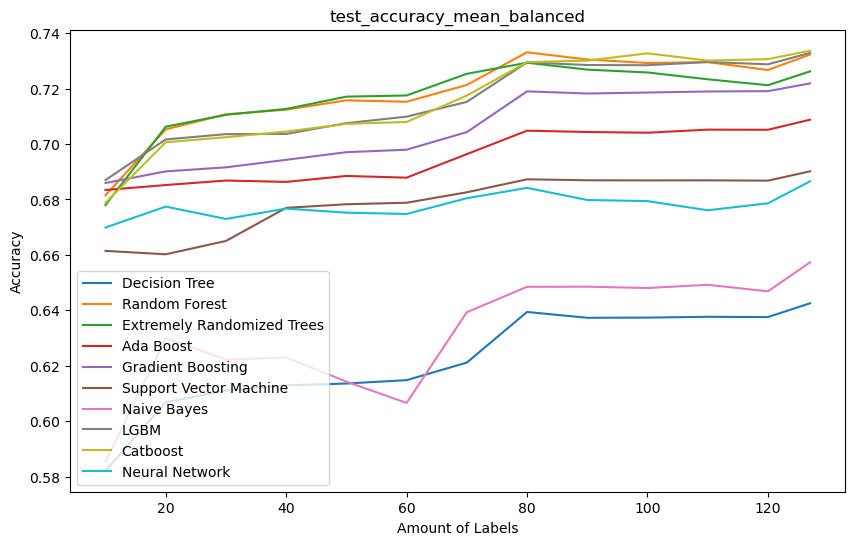

In [81]:
index = 0

number_of_features = [i for i in range(10, 121, 10)] + [127]

plt.figure(figsize=(10, 6))
for key, value in data_dict.items():
    plt.plot(number_of_features, deep_data_dict[f"{key}_{categories[index]}"], label=key)

plt.ylabel('Accuracy')  
plt.xlabel('Amount of Labels')  
plt.title(f'{categories[index]}') 
plt.legend()
plt.show()

In [82]:
for key, value in data_dict.items():
    max_value = max(deep_data_dict[f'{key}_{categories[index]}'])
    print(f"{key} ---- Max value: {max_value} --- Amount of Labels: {number_of_features[deep_data_dict[f'{key}_{categories[index]}'].index(max_value)]}")

Decision Tree ---- Max value: 0.6425270868449694 --- Amount of Labels: 127
Random Forest ---- Max value: 0.7331273914886547 --- Amount of Labels: 80
Extremely Randomized Trees ---- Max value: 0.7293542515287441 --- Amount of Labels: 80
Ada Boost ---- Max value: 0.7087910974893432 --- Amount of Labels: 127
Gradient Boosting ---- Max value: 0.7219025614519116 --- Amount of Labels: 127
Support Vector Machine ---- Max value: 0.690161772208074 --- Amount of Labels: 127
Naive Bayes ---- Max value: 0.6572888435781429 --- Amount of Labels: 127
LGBM ---- Max value: 0.7328915313175872 --- Amount of Labels: 127
Catboost ---- Max value: 0.7336933819444276 --- Amount of Labels: 127
Neural Network ---- Max value: 0.6865539962679522 --- Amount of Labels: 127
